# A guide Portfolio Optimization Environment

This notebook aims to provide an example of using PortfolioOptimizationEnv (or POE) to train a reinforcement learning model that learns to solve the portfolio optimization problem.

In this document, we will reproduce a famous architecture called EIIE (ensemble of identical independent evaluators), introduced in the following paper:

- Zhengyao Jiang, Dixing Xu, & Jinjun Liang. (2017). A Deep Reinforcement Learning Framework for the Financial Portfolio Management Problem. https://doi.org/10.48550/arXiv.1706.10059.

It's advisable to read it to understand the algorithm implemented in this notebook.

### Note
If you're using this environment, consider citing the following paper (in adittion to FinRL references):

- Caio Costa, & Anna Costa (2023). POE: A General Portfolio Optimization Environment for FinRL. In *Anais do II Brazilian Workshop on Artificial Intelligence in Finance* (pp. 132–143). SBC. https://doi.org/10.5753/bwaif.2023.231144.

```
@inproceedings{bwaif,
 author = {Caio Costa and Anna Costa},
 title = {POE: A General Portfolio Optimization Environment for FinRL},
 booktitle = {Anais do II Brazilian Workshop on Artificial Intelligence in Finance},
 location = {João Pessoa/PB},
 year = {2023},
 keywords = {},
 issn = {0000-0000},
 pages = {132--143},
 publisher = {SBC},
 address = {Porto Alegre, RS, Brasil},
 doi = {10.5753/bwaif.2023.231144},
 url = {https://sol.sbc.org.br/index.php/bwaif/article/view/24959}
}

```

## Installation and imports

To run this notebook in google colab, uncomment the cells below.

In [41]:
## install finrl library
# !sudo apt install swig
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

In [42]:
## We also need to install quantstats, because the environment uses it to plot graphs
# !pip install quantstats

In [43]:
## Hide matplotlib warnings
# import warnings
# warnings.filterwarnings('ignore')

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

#### Import the necessary code libraries

In [44]:
import torch

import numpy as np

from sklearn.preprocessing import MaxAbsScaler

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import GroupByScaler
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv
from finrl.agents.portfolio_optimization.models import DRLAgent
from finrl.agents.portfolio_optimization.architectures import EIIE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

## Fetch data

In his paper, *Jiang et al* creates a portfolio composed by the top-11 cryptocurrencies based on 30-days volume. Since it's not specified when this classification was done, it's difficult to reproduce, so we will use a similar approach in the Brazillian stock market:

- We select top-10 stocks from Brazillian stock market;
- For simplicity, we disconsider stocks that have missing data for the days in period 2011-01-01 to 2019-12-31 (9 years);

In [45]:
TOP_BRL = [
    "VALE3.SA", "PETR4.SA", "ITUB4.SA", "BBDC4.SA",
    "BBAS3.SA", "RENT3.SA", "LREN3.SA", "PRIO3.SA",
    "WEGE3.SA", "ABEV3.SA"
]

In [46]:
print(len(TOP_BRL))

portfolio_raw_df = YahooDownloader(start_date = '2011-01-01',
                                end_date = '2022-12-31',
                                ticker_list = TOP_BRL).fetch_data()
portfolio_raw_df

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

10



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Shape of DataFrame:  (29780, 8)


,date,open,high,low,close,volume,tic,day
0,2011-01-03,8.632311,8.728203,8.630313,5.265024,576145,ABEV3.SA,0
1,2011-01-03,15.750000,15.900000,15.690000,2.838269,6626800,BBAS3.SA,0
2,2011-01-03,11.809763,11.927362,11.724237,6.688100,10862336,BBDC4.SA,0
3,2011-01-03,18.031555,18.250118,17.963253,10.171988,10014663,ITUB4.SA,0
4,2011-01-03,8.422694,8.629907,8.422694,6.294305,3652542,LREN3.SA,0
...,...,...,...,...,...,...,...,...
29775,2022-12-29,24.990000,25.049999,24.430000,18.930288,57901800,PETR4.SA,3
29776,2022-12-29,37.250000,37.480000,36.619999,37.150330,7890300,PRIO3.SA,3
29777,2022-12-29,54.300869,55.776001,52.626392,51.326015,8786791,RENT3.SA,3
29778,2022-12-29,89.000000,89.949997,88.830002,80.014046,40110800,VALE3.SA,3


In [47]:
portfolio_raw_df.groupby("tic").count()

,date,open,high,low,close,volume,day
tic,,,,,,,
ABEV3.SA,2978,2978,2978,2978,2978,2978,2978
BBAS3.SA,2978,2978,2978,2978,2978,2978,2978
BBDC4.SA,2978,2978,2978,2978,2978,2978,2978
ITUB4.SA,2978,2978,2978,2978,2978,2978,2978
LREN3.SA,2978,2978,2978,2978,2978,2978,2978
PETR4.SA,2978,2978,2978,2978,2978,2978,2978
PRIO3.SA,2978,2978,2978,2978,2978,2978,2978
RENT3.SA,2978,2978,2978,2978,2978,2978,2978
VALE3.SA,2978,2978,2978,2978,2978,2978,2978


### Normalize Data

We normalize the data dividing the time series of each stock by its maximum value, so that the dataframe contains values between 0 and 1.

In [48]:
portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(portfolio_raw_df)
portfolio_norm_df

/home/caio/Documentos/FinRL/finrl/meta/preprocessor/preprocessors.py:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.00200262 0.00114137 0.0010422  ... 0.04565734 0.05214546 0.07760399]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, self.columns] = self.scalers[value].transform(
/home/caio/Documentos/FinRL/finrl/meta/preprocessor/preprocessors.py:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.   0.25 0.5  ... 0.25 0.5  0.75]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, self.columns] = self.scalers[value].transform(


,date,open,high,low,close,volume,tic,day
0,2011-01-03,0.353928,0.355383,0.359147,0.272027,0.002003,ABEV3.SA,0.00
1,2011-01-03,0.566547,0.568771,0.572419,0.157351,0.014581,BBAS3.SA,0.00
2,2011-01-03,0.396939,0.397479,0.399922,0.287841,0.021760,BBDC4.SA,0.00
3,2011-01-03,0.466293,0.458661,0.467793,0.322621,0.062331,ITUB4.SA,0.00
4,2011-01-03,0.153498,0.157120,0.155466,0.127001,0.072591,LREN3.SA,0.00
...,...,...,...,...,...,...,...,...
29775,2022-12-29,0.663745,0.652514,0.662958,0.694899,0.082841,PETR4.SA,0.75
29776,2022-12-29,0.858295,0.844144,0.878173,0.857373,0.048724,PRIO3.SA,0.75
29777,2022-12-29,0.737949,0.754746,0.727218,0.728887,0.097191,RENT3.SA,0.75
29778,2022-12-29,0.742905,0.746783,0.770759,0.916710,0.218546,VALE3.SA,0.75


In [49]:
df_portfolio = portfolio_norm_df[["date", "tic", "close", "high", "low"]]

df_portfolio_train = df_portfolio[(df_portfolio["date"] >= "2011-01-01") & (df_portfolio["date"] < "2019-12-31")]
df_portfolio_2020 = df_portfolio[(df_portfolio["date"] >= "2020-01-01") & (df_portfolio["date"] < "2020-12-31")]
df_portfolio_2021 = df_portfolio[(df_portfolio["date"] >= "2021-01-01") & (df_portfolio["date"] < "2021-12-31")]
df_portfolio_2022 = df_portfolio[(df_portfolio["date"] >= "2022-01-01") & (df_portfolio["date"] < "2022-12-31")]

### Instantiate Environment

Using the `PortfolioOptimizationEnv`, it's easy to instantiate a portfolio optimization environment for reinforcement learning agents. In the example below, we use the dataframe created before to start an environment.

In [50]:
environment = PortfolioOptimizationEnv(
        df_portfolio_train,
        initial_amount=100000,
        comission_fee_pct=0.0025,
        time_window=50,
        features=["close", "high", "low"],
        normalize_df=None
    )

### Instantiate Model

Now, we can instantiate the model using FinRL API. In this example, we are going to use the EIIE architecture introduced by Jiang et. al.

:exclamation: **Note:** Remember to set the architecture's `time_window` parameter with the same value of the environment's `time_window`.

In [51]:
# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "k_size": 3,
    "time_window": 50,
}

model = DRLAgent(environment).get_model("pg", device, model_kwargs, policy_kwargs)

### Train Model

In [52]:
DRLAgent.train_model(model, episodes=40)

  0%|          | 0/40 [00:00<?, ?it/s]

Initial portfolio value:100000
Final portfolio value: 385040.96875
Final accumulative portfolio value: 3.8504096875
Maximum DrawDown: -0.43694138095630164
Sharpe ratio: 0.8325641434157057


  2%|▎         | 1/40 [00:22<14:27, 22.23s/it]

Initial portfolio value:100000
Final portfolio value: 432366.90625
Final accumulative portfolio value: 4.3236690625
Maximum DrawDown: -0.440061257034582
Sharpe ratio: 0.9433159229705296


  5%|▌         | 2/40 [00:44<14:00, 22.11s/it]

Initial portfolio value:100000
Final portfolio value: 520977.8125
Final accumulative portfolio value: 5.209778125
Maximum DrawDown: -0.4695879959202859
Sharpe ratio: 0.9829064434985563


  8%|▊         | 3/40 [01:06<13:41, 22.19s/it]

Initial portfolio value:100000
Final portfolio value: 603017.0625
Final accumulative portfolio value: 6.030170625
Maximum DrawDown: -0.5303969892231588
Sharpe ratio: 0.9678411790552034


 10%|█         | 4/40 [01:28<13:17, 22.16s/it]

Initial portfolio value:100000
Final portfolio value: 691438.375
Final accumulative portfolio value: 6.91438375
Maximum DrawDown: -0.5345244999288666
Sharpe ratio: 1.0317940509881482


 12%|█▎        | 5/40 [01:50<12:52, 22.07s/it]

Initial portfolio value:100000
Final portfolio value: 823173.625
Final accumulative portfolio value: 8.23173625
Maximum DrawDown: -0.5652736234992821
Sharpe ratio: 1.035537312266153


 15%|█▌        | 6/40 [02:13<12:38, 22.32s/it]

Initial portfolio value:100000
Final portfolio value: 945736.9375
Final accumulative portfolio value: 9.457369375
Maximum DrawDown: -0.5914935086035373
Sharpe ratio: 1.0374710239521467


 18%|█▊        | 7/40 [02:35<12:13, 22.24s/it]

Initial portfolio value:100000
Final portfolio value: 969559.1875
Final accumulative portfolio value: 9.695591875
Maximum DrawDown: -0.6471614235017352
Sharpe ratio: 0.9770227278765214


 20%|██        | 8/40 [02:57<11:46, 22.09s/it]

Initial portfolio value:100000
Final portfolio value: 1104534.5
Final accumulative portfolio value: 11.045345
Maximum DrawDown: -0.6301651263519266
Sharpe ratio: 1.0237892697969757


 22%|██▎       | 9/40 [03:20<11:38, 22.54s/it]

Initial portfolio value:100000
Final portfolio value: 1119599.0
Final accumulative portfolio value: 11.19599
Maximum DrawDown: -0.6684622043532014
Sharpe ratio: 0.9801229201409899


 25%|██▌       | 10/40 [03:43<11:19, 22.64s/it]

Initial portfolio value:100000
Final portfolio value: 1268040.125
Final accumulative portfolio value: 12.68040125
Maximum DrawDown: -0.6547845447746306
Sharpe ratio: 1.0172949402189784


 28%|██▊       | 11/40 [04:06<10:59, 22.74s/it]

Initial portfolio value:100000
Final portfolio value: 1231757.125
Final accumulative portfolio value: 12.31757125
Maximum DrawDown: -0.6960534485362004
Sharpe ratio: 0.9604649744547805


 30%|███       | 12/40 [04:28<10:30, 22.52s/it]

Initial portfolio value:100000
Final portfolio value: 1405231.875
Final accumulative portfolio value: 14.05231875
Maximum DrawDown: -0.6633583007958319
Sharpe ratio: 1.0233517470008788


 32%|███▎      | 13/40 [04:50<10:06, 22.48s/it]

Initial portfolio value:100000
Final portfolio value: 1362994.625
Final accumulative portfolio value: 13.62994625
Maximum DrawDown: -0.7045986884989512
Sharpe ratio: 0.9665800237678901


 35%|███▌      | 14/40 [05:13<09:42, 22.40s/it]

Initial portfolio value:100000
Final portfolio value: 1459606.75
Final accumulative portfolio value: 14.5960675
Maximum DrawDown: -0.690705709307877
Sharpe ratio: 0.9914607276189837


 38%|███▊      | 15/40 [05:35<09:16, 22.26s/it]

Initial portfolio value:100000
Final portfolio value: 1490526.0
Final accumulative portfolio value: 14.90526
Maximum DrawDown: -0.6944851332843318
Sharpe ratio: 0.9812963829657945


 40%|████      | 16/40 [05:57<08:55, 22.32s/it]

Initial portfolio value:100000
Final portfolio value: 1549355.375
Final accumulative portfolio value: 15.49355375
Maximum DrawDown: -0.6933624028469978
Sharpe ratio: 0.9863412896316986


 42%|████▎     | 17/40 [06:20<08:34, 22.35s/it]

Initial portfolio value:100000
Final portfolio value: 1606115.75
Final accumulative portfolio value: 16.0611575
Maximum DrawDown: -0.69369766089119
Sharpe ratio: 0.9849120153612915


 45%|████▌     | 18/40 [06:43<08:16, 22.57s/it]

Initial portfolio value:100000
Final portfolio value: 1697176.5
Final accumulative portfolio value: 16.971765
Maximum DrawDown: -0.6837630642661545
Sharpe ratio: 0.9983994393963533


 48%|████▊     | 19/40 [07:05<07:55, 22.63s/it]

Initial portfolio value:100000
Final portfolio value: 1757279.375
Final accumulative portfolio value: 17.57279375
Maximum DrawDown: -0.6909155474653719
Sharpe ratio: 0.994707027829647


 50%|█████     | 20/40 [07:28<07:32, 22.60s/it]

Initial portfolio value:100000
Final portfolio value: 1830498.75
Final accumulative portfolio value: 18.3049875
Maximum DrawDown: -0.6930789420297205
Sharpe ratio: 0.996955913943652


 52%|█████▎    | 21/40 [07:51<07:10, 22.63s/it]

Initial portfolio value:100000
Final portfolio value: 1871996.125
Final accumulative portfolio value: 18.71996125
Maximum DrawDown: -0.7041261221075639
Sharpe ratio: 0.9863575412121732


 55%|█████▌    | 22/40 [08:13<06:48, 22.67s/it]

Initial portfolio value:100000
Final portfolio value: 1915910.25
Final accumulative portfolio value: 19.1591025
Maximum DrawDown: -0.7099325656210782
Sharpe ratio: 0.9814408191361197


 57%|█████▊    | 23/40 [08:36<06:24, 22.61s/it]

Initial portfolio value:100000
Final portfolio value: 1884170.375
Final accumulative portfolio value: 18.84170375
Maximum DrawDown: -0.7317997718333524
Sharpe ratio: 0.9543341181855992


 60%|██████    | 24/40 [08:58<05:58, 22.40s/it]

Initial portfolio value:100000
Final portfolio value: 1978879.625
Final accumulative portfolio value: 19.78879625
Maximum DrawDown: -0.7194680985917248
Sharpe ratio: 0.9743714326713419


 62%|██████▎   | 25/40 [09:21<05:38, 22.55s/it]

Initial portfolio value:100000
Final portfolio value: 2154036.75
Final accumulative portfolio value: 21.5403675
Maximum DrawDown: -0.6659672023127168
Sharpe ratio: 1.0360744568254021


 65%|██████▌   | 26/40 [09:43<05:14, 22.46s/it]

Initial portfolio value:100000
Final portfolio value: 1898927.25
Final accumulative portfolio value: 18.9892725
Maximum DrawDown: -0.7793056952332392
Sharpe ratio: 0.9144819413600235


 68%|██████▊   | 27/40 [10:06<04:53, 22.56s/it]

Initial portfolio value:100000
Final portfolio value: 1993799.0
Final accumulative portfolio value: 19.93799
Maximum DrawDown: -0.7006401932993662
Sharpe ratio: 1.0057436299325901


 70%|███████   | 28/40 [10:28<04:28, 22.39s/it]

Initial portfolio value:100000
Final portfolio value: 2330999.25
Final accumulative portfolio value: 23.3099925
Maximum DrawDown: -0.6696759833063628
Sharpe ratio: 1.0477967195638818


 72%|███████▎  | 29/40 [10:50<04:07, 22.50s/it]

Initial portfolio value:100000
Final portfolio value: 1937146.0
Final accumulative portfolio value: 19.37146
Maximum DrawDown: -0.7936668482286839
Sharpe ratio: 0.9054145210236558


 75%|███████▌  | 30/40 [11:13<03:44, 22.47s/it]

Initial portfolio value:100000
Final portfolio value: 1709073.0
Final accumulative portfolio value: 17.09073
Maximum DrawDown: -0.7492562302933228
Sharpe ratio: 0.9294165846919152


 78%|███████▊  | 31/40 [11:35<03:21, 22.42s/it]

Initial portfolio value:100000
Final portfolio value: 1988512.625
Final accumulative portfolio value: 19.88512625
Maximum DrawDown: -0.6967059065829422
Sharpe ratio: 1.0133491769379754


 80%|████████  | 32/40 [11:57<02:58, 22.25s/it]

Initial portfolio value:100000
Final portfolio value: 2280850.0
Final accumulative portfolio value: 22.8085
Maximum DrawDown: -0.6308013843352027
Sharpe ratio: 1.0827259449091051


 82%|████████▎ | 33/40 [12:20<02:37, 22.49s/it]

Initial portfolio value:100000
Final portfolio value: 2535594.75
Final accumulative portfolio value: 25.3559475
Maximum DrawDown: -0.7054483480941727
Sharpe ratio: 1.0358760032435206


 85%|████████▌ | 34/40 [12:43<02:15, 22.52s/it]

Initial portfolio value:100000
Final portfolio value: 1853363.125
Final accumulative portfolio value: 18.53363125
Maximum DrawDown: -0.80204361278234
Sharpe ratio: 0.8861850629786099


 88%|████████▊ | 35/40 [13:05<01:52, 22.42s/it]

Initial portfolio value:100000
Final portfolio value: 1976948.875
Final accumulative portfolio value: 19.76948875
Maximum DrawDown: -0.7012713940750688
Sharpe ratio: 1.0144723339300001


 90%|█████████ | 36/40 [13:28<01:30, 22.63s/it]

Initial portfolio value:100000
Final portfolio value: 1496496.375
Final accumulative portfolio value: 14.96496375
Maximum DrawDown: -0.598138804949116
Sharpe ratio: 1.1625482738032367


 92%|█████████▎| 37/40 [13:50<01:07, 22.54s/it]

Initial portfolio value:100000
Final portfolio value: 1573181.25
Final accumulative portfolio value: 15.7318125
Maximum DrawDown: -0.5894304176343221
Sharpe ratio: 1.1632205152623596


 95%|█████████▌| 38/40 [14:12<00:44, 22.43s/it]

Initial portfolio value:100000
Final portfolio value: 1642286.0
Final accumulative portfolio value: 16.42286
Maximum DrawDown: -0.5931878962991857
Sharpe ratio: 1.1784491119243807


 98%|█████████▊| 39/40 [14:35<00:22, 22.55s/it]

Initial portfolio value:100000
Final portfolio value: 1716964.375
Final accumulative portfolio value: 17.16964375
Maximum DrawDown: -0.5883583583593176
Sharpe ratio: 1.1939969246876079


100%|██████████| 40/40 [14:58<00:00, 22.46s/it]


### Save Model

In [53]:
torch.save(model.train_policy.state_dict(), "policy_EIIE.pt")

## Test Model

### Instantiate different environments

Since we have three different periods of time, we need three different environments instantiated to simulate them.

In [54]:
environment_2020 = PortfolioOptimizationEnv(
    df_portfolio_2020,
    initial_amount=100000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=["close", "high", "low"],
    normalize_df=None
)

environment_2021 = PortfolioOptimizationEnv(
    df_portfolio_2021,
    initial_amount=100000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=["close", "high", "low"],
    normalize_df=None
)

environment_2022 = PortfolioOptimizationEnv(
    df_portfolio_2022,
    initial_amount=100000,
    comission_fee_pct=0.0025,
    time_window=50,
    features=["close", "high", "low"],
    normalize_df=None
)

### Test EIIE architecture
Now, we can test the EIIE architecture in the three different test periods. It's important no note that, in this code, we load the saved policy even though it's not necessary just to show how to save and load your model.

In [55]:
EIIE_results = {
    "training": environment._asset_memory["final"],
    "2020": {},
    "2021": {},
    "2022": {}
}

# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
policy = EIIE(time_window=50, device=device)
policy.load_state_dict(torch.load("policy_EIIE.pt"))

# 2020
DRLAgent.DRL_validation(model, environment_2020, policy=policy)
EIIE_results["2020"]["value"] = environment_2020._asset_memory["final"]

# 2021
DRLAgent.DRL_validation(model, environment_2021, policy=policy)
EIIE_results["2021"]["value"] = environment_2021._asset_memory["final"]

# 2022
DRLAgent.DRL_validation(model, environment_2022, policy=policy)
EIIE_results["2022"]["value"] = environment_2022._asset_memory["final"]

Initial portfolio value:100000
Final portfolio value: 300425.875
Final accumulative portfolio value: 3.00425875
Maximum DrawDown: -0.44018999999999997
Sharpe ratio: 1.9037659723061418
Initial portfolio value:100000
Final portfolio value: 135694.625
Final accumulative portfolio value: 1.35694625
Maximum DrawDown: -0.1553491952446484
Sharpe ratio: 1.412587489380964
Initial portfolio value:100000
Final portfolio value: 101662.1484375
Final accumulative portfolio value: 1.016621484375
Maximum DrawDown: -0.2406645708757662
Sharpe ratio: 0.2027036585970349


### Test Uniform Buy and Hold
For comparison, we will also test the performance of a uniform buy and hold strategy. In this strategy, the portfolio has no remaining cash and the same percentage of money is allocated in each asset.

In [56]:
UBAH_results = {
    "train": {},
    "2020": {},
    "2021": {},
    "2022": {}
}

PORTFOLIO_SIZE = len(TOP_BRL)

# train period
terminated = False
environment.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment.step(action)
UBAH_results["train"]["value"] = environment._asset_memory["final"]

# 2020
terminated = False
environment_2020.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2020.step(action)
UBAH_results["2020"]["value"] = environment_2020._asset_memory["final"]

# 2021
terminated = False
environment_2021.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2021.step(action)
UBAH_results["2021"]["value"] = environment_2021._asset_memory["final"]

# 2022
terminated = False
environment_2022.reset()
while not terminated:
    action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
    _, _, terminated, _ = environment_2022.step(action)
UBAH_results["2022"]["value"] = environment_2022._asset_memory["final"]

Initial portfolio value:100000
Final portfolio value: 422020.28125
Final accumulative portfolio value: 4.2202028125
Maximum DrawDown: -0.47191689613863286
Sharpe ratio: 0.8074281745795617
Initial portfolio value:100000
Final portfolio value: 171398.5
Final accumulative portfolio value: 1.713985
Maximum DrawDown: -0.250788671875
Sharpe ratio: 1.7169357267189664
Initial portfolio value:100000
Final portfolio value: 96248.625
Final accumulative portfolio value: 0.96248625
Maximum DrawDown: -0.1693852421222789
Sharpe ratio: -0.12241539200411489
Initial portfolio value:100000
Final portfolio value: 113848.515625
Final accumulative portfolio value: 1.13848515625
Maximum DrawDown: -0.16645801969650909
Sharpe ratio: 0.8294354891818461


### Plot graphics

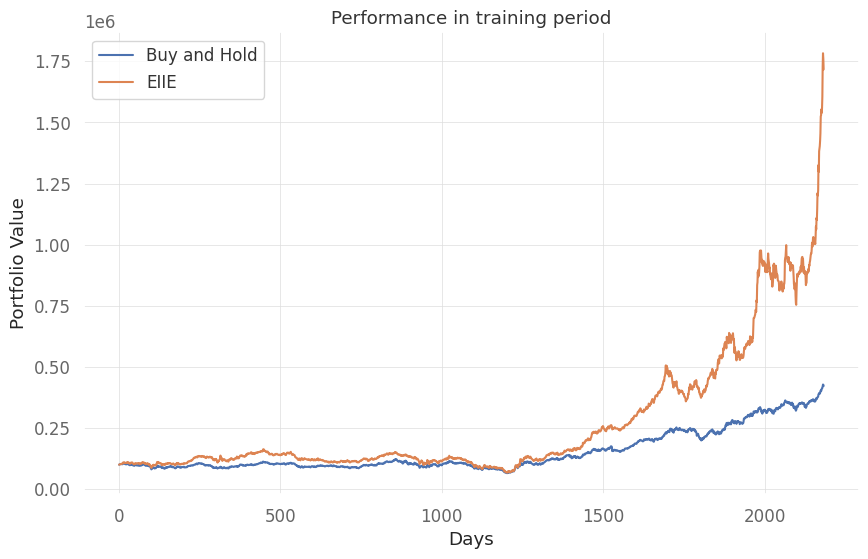

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(UBAH_results["train"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["training"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()

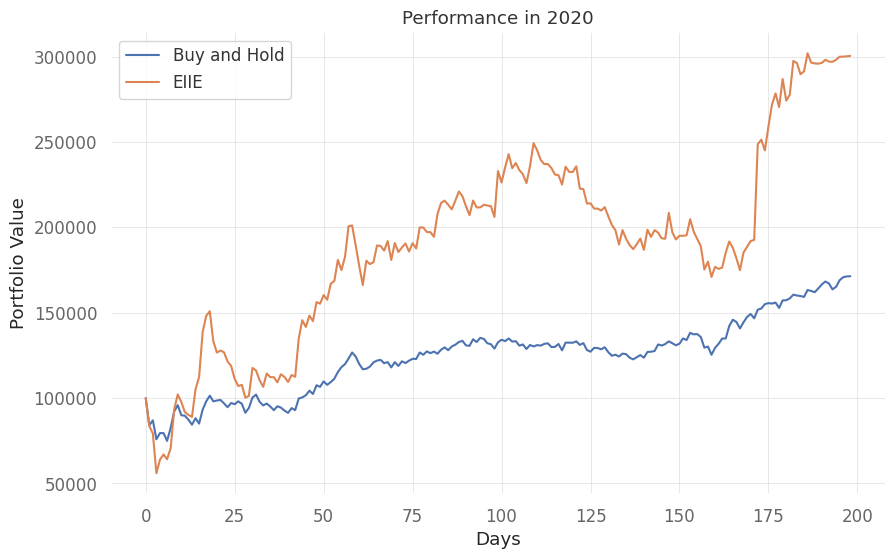

In [58]:
plt.plot(UBAH_results["2020"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2020"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2020")
plt.legend()

plt.show()

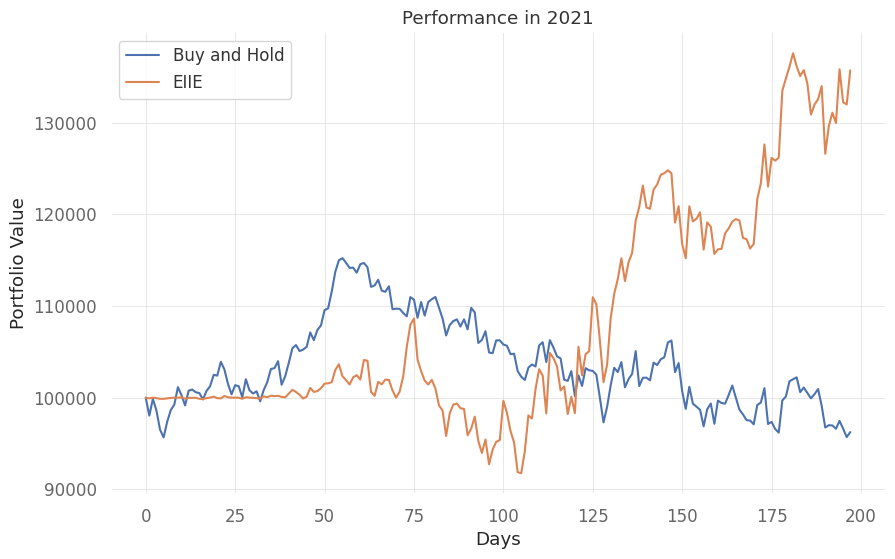

In [59]:
plt.plot(UBAH_results["2021"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2021"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2021")
plt.legend()

plt.show()

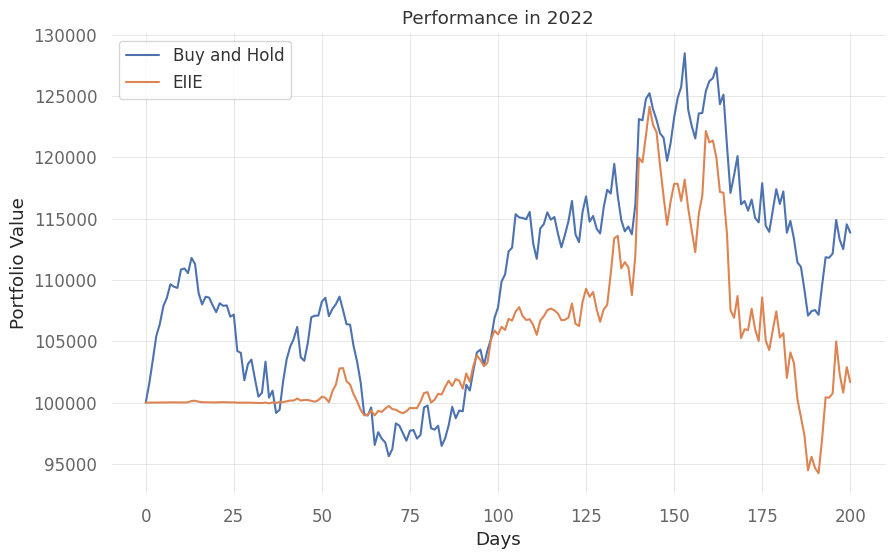

In [60]:
plt.plot(UBAH_results["2022"]["value"], label="Buy and Hold")
plt.plot(EIIE_results["2022"]["value"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2022")
plt.legend()

plt.show()

We can see that the agent is able to learn a good policy but its performance is worse the more the test period advances into the future. To get a better performance in 2022, for example, the agent should probably be trained again using more recent data.